<a href="https://colab.research.google.com/github/shern2/colab-notes/blob/main/Automated_NLG_Validation_Detect%2C_Retrieve%2C_%26_Factcheck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Validating AI-Genereated product descriptions
The main objective of this notebook is to:
1. Validate a number of product descriptions that are generated by an AI
2. Return the set of attributes that are found as well as those that are missing from the product description
3. Evaluate the correctness of the information present in the product description

This validation process also works for product descriptions generated by a person.

By validation, we refer to the mechanism of finding specific information in a product description.

## This work is divided into 5 main sections: </br>
1. Get the data
2. Prepare the main functions
3. Run the labeling functions
4. Detect and retrieve key information
5. Highlight and process


Running this colab will try to detect and highlight the following attributes whenever they are available in a product description, otherwise they'll be reported as missing.

The use case is specific to each domain. In this work, we target the category of sunglasses and eyeglasses.

## Here are the attributes that are supported:

* Brand
* Product type
* Model name
* Audience or gender
* Lens material
* Frame material
* Lens color
* Temple color

---

<table align="left">
  <td>
  <a href="https://wordlift.io">
    <img width=130px src="https://wordlift.io/wp-content/uploads/2018/07/logo-assets-510x287.png" />
    </a>
    </td>
    <td>
      by 
      <a href="https://www.linkedin.com/in/erdphd/">
        Elie Raad
      </a>
      <br/>
      <br/>
       MIT License (for this Colab)
      <br/>
       Apache 2.0 License (for snorkel).
      <br/>
      <br/>
      <i>Last updated: <b>December 1st, 2021</b></i>
  </td>
</table>
</br>
</br>

## **The input:** A sample product description

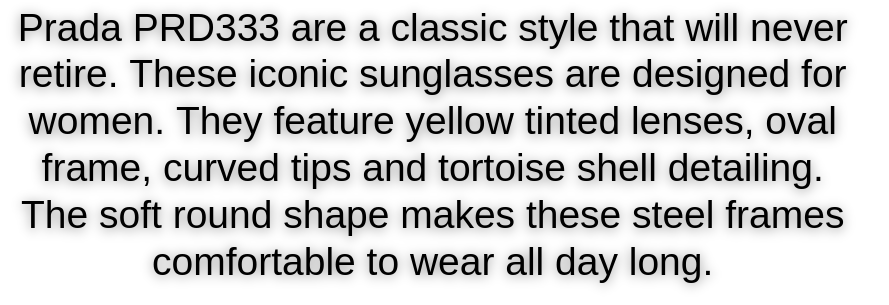

## **The output:** A highlighted version of the input that adds a background color to the extracted values of a number of specific attributes

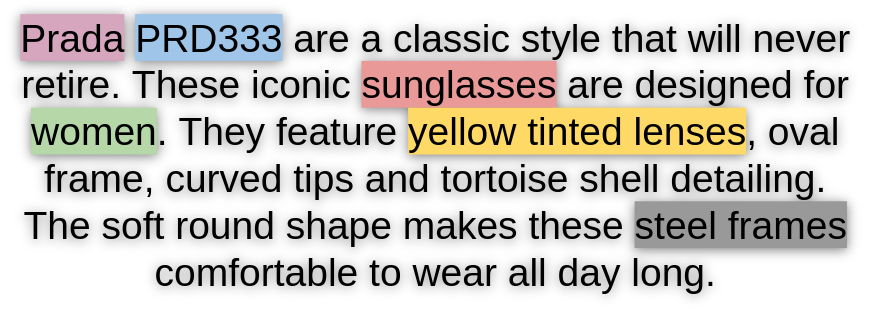

In [ ]:
%%capture
!pip install snorkel
!pip install webcolors
!pip install termcolor
!pip install spacy
!pip install nltk
! python -m spacy download en_core_web_sm

In [ ]:
%%capture
%matplotlib inline

import os
import re
import string
import numpy as np
import pandas as pd

from snorkel.labeling import LFAnalysis
from snorkel.labeling import PandasLFApplier
from snorkel.analysis import get_label_buckets
from snorkel.labeling import LabelingFunction
from snorkel.labeling import labeling_function

import spacy
from termcolor import colored, cprint
import webcolors

import nltk
nltk.download("popular")
from nltk.util import ngrams 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

DISPLAY_ALL_TEXT = True
pd.set_option("display.max_colwidth", 0 if DISPLAY_ALL_TEXT else 50)

def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
        text = re.sub("’", "", text)
    return text

## 1. Get the data
### Provide a product description

In [ ]:
product_descriptions = ["Prada PRD3700 sunglasses are a bestseller that continues to stand the test of time. This classic shape has been worn by cultural intellectuals who have changed the course of the world. With gold temples and yellow lenses, you’ll always be one step ahead. Lenses are polarized lenses to keep your eyes protected and safe from harmful UVA and UVB rays.",
                       "Prada PRD3700 eyeglasses are a bestseller that continues to stand the test of time. This classic shape has been worn by cultural intellectuals who have changed the course of the world. With gold temples and blue lenses, you’ll always be one step ahead. Lenses are polarized lenses to keep your eyes protected and safe from harmful UVA and UVB rays.",
                       "Shop Pre-Owned Prada 1990s Tinted Rounded Sunglasses In Gold from 250+ stores, starting at $209. Similar ones also available. On SALE now! Brown/gold-tone gold plated metal 1990s tinted rounded sunglasses from Prada Pre-Owned featuring yellow tinted lenses, oval frame, curved tips, nose pads and tortoiseshell detailing. Please be mindful that this piece has led a previous life, and may tell its story through minor imperfection. Purchasing this item continues its narrative, so you can be confident that you’re making a POSITIVELY CONSCIOUS choice for the planet . We know you’ll look after them, but these glasses come with protection, just in case."
]

In [ ]:
df_descriptions = pd.DataFrame(data=zip(range(1,len(product_descriptions)+1), product_descriptions), columns=['item_number','completion'])
df_descriptions["completion"] = df_descriptions['completion'].apply(remove_punctuations)
df_descriptions = df_descriptions.apply(lambda x: x.astype(str).str.lower())
df_descriptions
dfStyler = df_descriptions.style.set_properties(**{'text-align': 'left', 'font-size': '16pt'})
dfStyler.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

,item_number,completion
0,1,prada prd3700 sunglasses are a bestseller that continues to stand the test of time this classic shape has been worn by cultural intellectuals who have changed the course of the world with gold temples and yellow lenses youll always be one step ahead lenses are polarized lenses to keep your eyes protected and safe from harmful uva and uvb rays
1,2,prada prd3700 eyeglasses are a bestseller that continues to stand the test of time this classic shape has been worn by cultural intellectuals who have changed the course of the world with gold temples and blue lenses youll always be one step ahead lenses are polarized lenses to keep your eyes protected and safe from harmful uva and uvb rays
2,3,shop preowned prada 1990s tinted rounded sunglasses in gold from 250 stores starting at 209 similar ones also available on sale now browngoldtone gold plated metal 1990s tinted rounded sunglasses from prada preowned featuring yellow tinted lenses oval frame curved tips nose pads and tortoiseshell detailing please be mindful that this piece has led a previous life and may tell its story through minor imperfection purchasing this item continues its narrative so you can be confident that youre making a positively conscious choice for the planet we know youll look after them but these glasses come with protection just in case


## 2. The main validation functions

### a) Define the context of the labeling

In [ ]:
# We define constants to represent the class labels.
ABSTAIN = 0 # Not sure if the key information is present or not
INCOMPLETE = -1 # Key information is missing from the description
COMPLETE = 1 # Key information is present in the description

product_code = "prd"
product_brand = "prada"

### b) Writing a number of labeling functions (LFs) to identify specific elements in the descriptions

1. Keyword LFs: Search for specific keywords in the product description

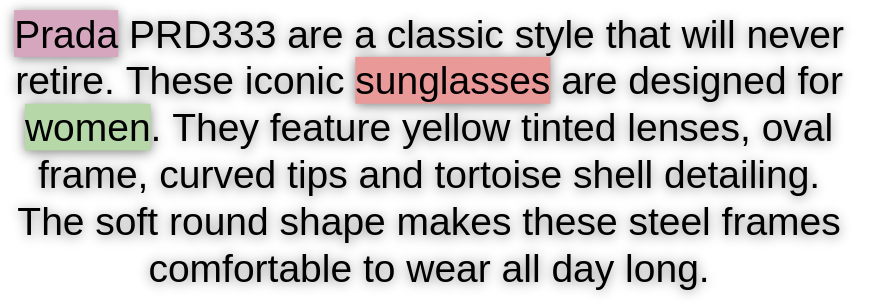

In [ ]:
def keyword_lookup(x, keywords, label):

    w_default = "something wrong"
    x = ''.join([c for c in x])

    w_list = []

    for w in x.split(' '):
      if w in keywords:
        w_list.append(w)

    if phase == 'detect':
      if w_list:
        return label
      return INCOMPLETE
    else:
      if w_list:
        return w_list
      return w_default

def make_keyword_lf(keywords, label=COMPLETE):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )

# Description actually talks about the brand
the_brand = ["prada"]
keyword_brand = make_keyword_lf(keywords=the_brand)

# Description mentions the category of the product
the_product = ["eyeglasses", "sunglasses"]
keyword_product_type = make_keyword_lf(keywords=the_product)

# Description mentions the gender or the age of the target user
the_audience = ["unisex", "men", "women", "kid",  "kids", "masculine", "feminine"]
keyword_gender = make_keyword_lf(keywords=the_audience)

2. Pattern-matching LFs using regular expressions

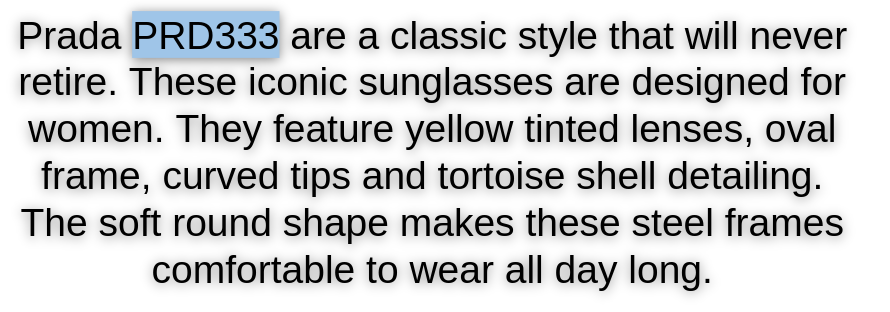

In [ ]:
@labeling_function()
def regex_check_product_name_w_code(x):
    return COMPLETE if re.search(r"(" + product_code + ")([\w-]+)", x.completion, flags=re.I) else INCOMPLETE

@labeling_function()
def regex_check_product_name_pattern_a(x):
    return COMPLETE if re.search(r"(" + product_brand + ")\s*\w+\s*(sunglasses|eyeglasses)\sare\b", x.completion, flags=re.I) else INCOMPLETE

@labeling_function()
def regex_check_product_name_pattern_b(x):
    return COMPLETE if re.search(r"(the)\s+\w+\s*(sunglasses|eyeglasses)\sare\b", x.completion, flags=re.I) else INCOMPLETE

3.  Heuristic LFs

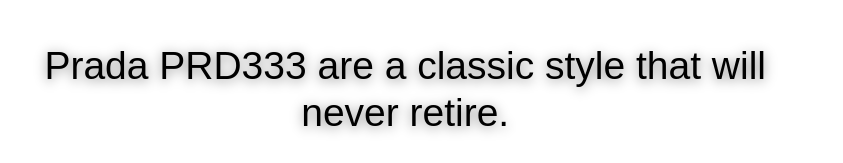

In [ ]:
@labeling_function()
def short_completion(x):
    """we might want to avoid very short product descriptions, such as 'cool sunglasses!'"""
    return INCOMPLETE if len(x.completion.split()) < 35 else COMPLETE

4. LFs with advanced preprocessors

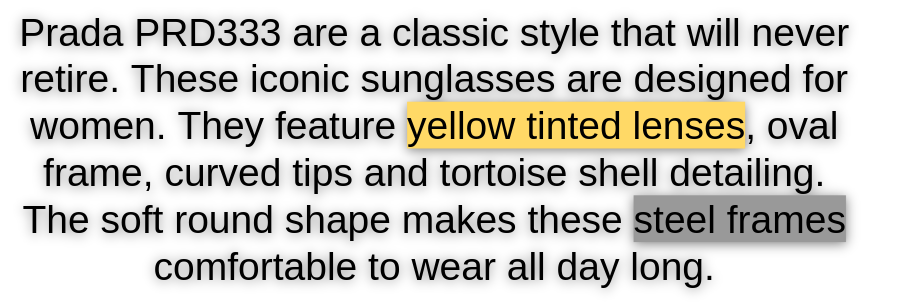

In [ ]:
class ColorFinder:
    """Extract colors along with adjectives"""

    def __init__(self):
        #self.colours = colours
        self.pos_ok = ['ADJ', 'NOUN', 'VERB']
        self.tagger = spacy.load('en_core_web_sm')

    def get(self, string, component):
        extracted = set()
        doc = self.tagger(string.lower())
        
        pairs = [(word.text, word.pos_) for word in doc]
        for index, pair in enumerate(pairs):
            text, pos = pair
            if text in webcolors.CSS3_NAMES_TO_HEX:
                text_ahead = self.look_ahead(pairs=pairs, index=index, component=component)
                text_behind = self.look_behind(pairs=pairs, index=index,
                                               colour_pos=pos, component=component)
                if text_behind:
                    text_behind.append(text)
                    if text_ahead:
                        text_behind.extend(text_ahead)
                        extracted.add(' '.join(text_behind))
                    else:
                        extracted.add(' '.join(text_behind))
                elif text_ahead:
                    extracted.add(' '.join([text] + text_ahead))
        return extracted if extracted else False


    def look_ahead(self, pairs, index, component):
        ahead = list()
        force_stop = ['and']

        for text, pos in pairs[index+1:index+5]:
            if text in force_stop:
              break
            elif ((pos in self.pos_ok) and (text in component)):
                ahead.append(text)

        return ahead if ahead else False
    
    def look_behind(self, pairs, index, colour_pos, component):
        behind = list()
        force_stop = ['and']

        for text, pos in reversed(pairs[index-5:index]):
            if text in force_stop:
              break
            elif ((pos in self.pos_ok) and (text in component)):
                behind.append(text)

        return list(reversed(behind)) if behind else False

class GeneralFinder:
    """Extract colours along with adjectives"""

    def __init__(self):
        self.pos_ok = ['ADJ', 'NOUN', 'VERB']
        self.tagger = spacy.load('en_core_web_sm')

    def get(self, string, component, describers):
        extracted = set()
        doc = self.tagger(string.lower())
        pairs = [(word.text, word.pos_) for word in doc]
        for index, pair in enumerate(pairs):
            text, pos = pair
            if text in describers:
                text_ahead = self.look_ahead(pairs=pairs, index=index, component=component)
                text_behind = self.look_behind(pairs=pairs, index=index,
                                               colour_pos=pos, component=component)
                if text_behind:
                    text_behind.append(text)
                    if text_ahead:
                        text_behind.extend(text_ahead)
                        extracted.add(' '.join(text_behind))
                    else:
                        extracted.add(' '.join(text_behind))
                elif text_ahead:
                    extracted.add(' '.join([text] + text_ahead))

        return extracted if extracted else False

    def look_ahead(self, pairs, index, component):
        ahead = list()
        for text, pos in pairs[index+1:index+4]:
            if ((pos in self.pos_ok) and (text in component)):
                ahead.append(text)

        return ahead if ahead else False

    def look_behind(self, pairs, index, colour_pos, component):
        behind = list()
        for text, pos in reversed(pairs[index-3:index]):
            if ((pos in self.pos_ok) and (text in component)):
                behind.append(text)

        return list(reversed(behind)) if behind else False

In [ ]:
# Description mentions for the lens colors
lens_color_components = ['lens', 'lenses']

# Description mentions for the temples colors
temple_color_components = ['temple', 'temples']

# Description mentions for the lens material
lens_material_describers = ['crystal', 'policarbonato', 'not glass', 'glass', 'polycarbonate', 'pa', 'nxt', 'demo lens', 'cristallo']
lens_material_components = ['lens', 'lenses']

# Description mentions for the frame material
frame_describers = ['premium materials', 'nylon', 'lightray titanium', 'metal', 'injected', 'acetate', 'steel', 'liteforce', 'peek', 'titanium', 'propionate']
frame_components = ['frame', 'frames']

In [ ]:
extractor = ColorFinder()
gen_extractor = GeneralFinder()

@labeling_function()
def mentions_lens_color(x):
    extracted_components = extractor.get(string=x.completion, component=lens_color_components)
    if phase == 'detect':
      if extracted_components:
        return COMPLETE
      else:
        return INCOMPLETE
    else:
      if extracted_components:
        return list(extracted_components)
      else:
        return "something wrong"

@labeling_function()
def mentions_temples_color(x):
    extracted_components = extractor.get(string=x.completion, component=temple_color_components)
    #print(extracted_components)
    if phase == 'detect':
      if extracted_components:
          return COMPLETE
      else:
          return INCOMPLETE
    else:
      if extracted_components:
        return list(extracted_components)
      else:
        return "something wrong"

@labeling_function()
def mentions_lens_material(x):
    extracted_components = gen_extractor.get(string=x.completion, component=lens_material_components, describers=lens_material_describers)
    if phase == 'detect':
      if extracted_components:
          return COMPLETE
      else:
          return INCOMPLETE
    else:
      if extracted_components:
        return list(extracted_components)
      else:
        return "something wrong"

@labeling_function()
def mentions_frames_material(x):
    extracted_components = gen_extractor.get(string=x.completion, component=frame_components, describers=frame_describers)
    if phase == 'detect':
      if extracted_components:
          return COMPLETE
      else:
          return INCOMPLETE
    else:
      if extracted_components:
        return list(extracted_components)
      else:
        return "something wrong"

## 3. Run the labeling functions for the **detection phase**
The detection phase allows answering all sort of questions related to the presence or the absence of an attribute.
It isn't meant to highlight the found key information. Highlighting is handled by the retrieval phase (phase = extract).

### Call snorkel's labeling function appliers

In [ ]:
phase = 'detect'

lfs = [
    regex_check_product_name_w_code,
    regex_check_product_name_pattern_a,
    regex_check_product_name_pattern_b,
    keyword_brand,
    keyword_product_type,
    keyword_gender,
    mentions_lens_material,
    mentions_frames_material,
    mentions_lens_color,
    mentions_temples_color
]

applier = PandasLFApplier(lfs=lfs)
L_descriptions = applier.apply(df=df_descriptions[['completion']])

100%|██████████| 3/3 [00:00<00:00, 11.84it/s]


### For large datasets, metrics such as the coverage, overlaps, and conflicts are valuable

In [ ]:
LFAnalysis(L=L_descriptions, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
regex_check_product_name_w_code,0,[1],0.666667,0.666667,0.0
regex_check_product_name_pattern_a,1,[],0.000000,0.000000,0.0
regex_check_product_name_pattern_b,2,[],0.000000,0.000000,0.0
keyword_prada,3,[1],1.000000,1.000000,0.0
keyword_eyeglasses,4,[1],1.000000,1.000000,0.0
keyword_unisex,5,[],0.000000,0.000000,0.0
mentions_lens_material,6,[],0.000000,0.000000,0.0
mentions_frames_material,7,[],0.000000,0.000000,0.0
mentions_lens_color,8,[1],1.000000,1.000000,0.0
mentions_temples_color,9,[1],0.666667,0.666667,0.0


### Create a single dataframe that combine the product description and snorkel's results

In [ ]:
df_labels = pd.DataFrame(list(L_descriptions), columns=[
    'product_name_w_code',
    'product_name_pattern_a',
    'product_name_pattern_b',
    'keyword_brand',
    'keyword_product_type',
    'keyword_gender',
    'mentions_lens_material',
    'mentions_frames_material',
    'mentions_lens_color',
    'mentions_temples_color'])

df_sno = pd.concat([df_descriptions, df_labels], axis=1)

## 4. Detect and retrieve key information for the **retrieval phase**
The goal of this phase is to search for and highlight the value of the found attribute

### Dictionary of the attributes (key information) that are supported
Specific values can be directly provided here or in their respective functions

In [ ]:
phase='extract'
info_keys = ['keyword_gender', 'keyword_brand', 'keyword_product_type', 'mentions_lens_color', 'product_name', 'mentions_lens_material', 'mentions_frames_material', 'mentions_temples_color']

dict_value_lists = [
  {"gender_keywords": the_audience},
  {"brand_keywords": the_brand},
  {"product_type_keywords": the_product},
  {"mentions_lens_color": []},
  {"product_name": []},
  {"mentions_lens_material": []},
  {"mentions_frames_material": []},
  {"mentions_temples_color": []},
]

df_sno['product_name_ab'] = df_sno['product_name_pattern_a'] + df_sno['product_name_pattern_a']
df_sno = df_sno.drop(['product_name_pattern_a', 'product_name_pattern_b'], axis=1)
df_sno.head(1)

,item_number,completion,product_name_w_code,keyword_brand,keyword_product_type,keyword_gender,mentions_lens_material,mentions_frames_material,mentions_lens_color,mentions_temples_color,product_name_ab
0,1,prada prd3700 sunglasses are a bestseller that continues to stand the test of time this classic shape has been worn by cultural intellectuals who have changed the course of the world with gold temples and yellow lenses youll always be one step ahead lenses are polarized lenses to keep your eyes protected and safe from harmful uva and uvb rays,1,1,1,-1,-1,-1,1,1,-2


### Attribute-specialized functions

#### Product name

In [ ]:
def get_product_name_w_code(x):
    factual_info_list = []
    factual_info =  None

    for index, row in x.iterrows():
      match = re.search(r"(" + product_code + ")([\w-]+)", row.completion, flags=re.I)
      
      if match:
        factual_info = [match.group()], row['item_number'], row['completion']
      else:
        factual_info = "something wrong"

      if factual_info == "something wrong":
        factual_info = get_product_name_pattern_a(row)

      if factual_info == "something wrong":
        factual_info = get_product_name_pattern_b(row)

      if factual_info == "something wrong":
        factual_info = "something wrong", row['item_number'], row['completion']

      factual_info_list.append(factual_info)

    return factual_info_list 

def get_product_name_pattern_a(row):
    factual_info_list = []
    factual_info =  None

    match = re.search(r"(" + product_brand + ")\s*\w+\s*(sunglasses|eyeglasses)\sare\b", row.completion, flags=re.I)
    
    if match:
      factual_info = [match.group()], row['item_number'], row['completion']
    else:
      factual_info = "something wrong"
        
    return factual_info

def get_product_name_pattern_b(row):
    factual_info_list = []
    factual_info =  None

    match = re.search(r"(the)\s+\w+\s*(sunglasses|eyeglasses)\sare\b", row.completion, flags=re.I)
      
    if match:
      factual_info = [match.group()], row['item_number'], row['completion']
    else:
      factual_info = "something wrong"
        
    return factual_info

def get_keywords_completion(x, keywords):
  factual_info_list = []

  for index, row in x.iterrows():
    factual_info = keyword_lookup(row['completion'],keywords=keywords, label=None), row['item_number'], row['completion']
    factual_info_list.append(factual_info)
    
  return factual_info_list

def get_mention_completion(x, extractor):
  factual_info_list = []

  for index, row in x.iterrows():
    factual_info = extractor(row), row['item_number'], row['completion']
    factual_info_list.append(factual_info)

  return factual_info_list

## 5. Process and highlight

### Function to detect the terms of interest

In [ ]:
def find_terms_of_interest(data, source_type, info_key_attributes):
  col_key = []
  results_all_data  = []

  for info_key_attribute in info_key_attributes:
      print("Working on %s" %info_key_attribute)

      info_key_index = info_key_attributes.index(info_key_attribute)
      keyword_values = list(dict_value_lists[info_key_index].values())[0]

      if info_key_attribute == 'mentions_lens_color':
        col_values = get_mention_completion(data,  mentions_lens_color)

      elif info_key_attribute == 'mentions_temples_color':
          col_values = get_mention_completion(data, mentions_temples_color)

      elif info_key_attribute == 'mentions_lens_material':
          col_values = get_mention_completion(data, mentions_lens_material)

      elif info_key_attribute == 'mentions_frames_material':
          col_values = get_mention_completion(data, mentions_frames_material)

      elif info_key_attribute == 'product_name':
        col_values = get_product_name_w_code(data)

        if col_values[0] is not None:
          col_values = get_product_name_w_code(data)

      else:
        col_values = get_keywords_completion(data, keyword_values)

      results_all_data.append(col_values)

  return results_all_data

## 5.1 Retrieval: Process the detected key info

In [ ]:
results_all_detected_facts = []
results_all_feed_facts = []
results_all_detected_facts = find_terms_of_interest(df_sno, 'detected', info_keys)

Working on keyword_gender
Working on keyword_brand
Working on keyword_product_type
Working on mentions_lens_color
Working on product_name
Working on mentions_lens_material
Working on mentions_frames_material
Working on mentions_temples_color


### Create a dataframe that contain the value of the detected attributes

In [ ]:
from functools import reduce

df_detected_facts_0 = pd.DataFrame(results_all_detected_facts[0], columns =['Detected_gender', 'item_number', 'completion'])
df_detected_facts_1 = pd.DataFrame(results_all_detected_facts[1], columns =['Detected_brand', 'item_number', 'completion'])
df_detected_facts_2 = pd.DataFrame(results_all_detected_facts[2], columns =['Detected_product_type', 'item_number', 'completion'])
df_detected_facts_3 = pd.DataFrame(results_all_detected_facts[3], columns =['Detected_lens_color', 'item_number', 'completion'])
df_detected_facts_4 = pd.DataFrame(results_all_detected_facts[4], columns =['Detected_product_name', 'item_number', 'completion'])
df_detected_facts_5 = pd.DataFrame(results_all_detected_facts[5], columns =['Detected_lens_material', 'item_number', 'completion'])
df_detected_facts_6 = pd.DataFrame(results_all_detected_facts[6], columns =['Detected_frames_material', 'item_number', 'completion'])
df_detected_facts_7 = pd.DataFrame(results_all_detected_facts[7], columns =['Detected_temples_color', 'item_number', 'completion'])

data_frames = [df_detected_facts_0, df_detected_facts_1, df_detected_facts_2, df_detected_facts_3, df_detected_facts_4, df_detected_facts_5, 
               df_detected_facts_6, df_detected_facts_7]
df_detected_facts_merged = reduce(lambda  left,right: pd.merge(left,right,on=['item_number'], how='outer'), data_frames)
print(df_detected_facts_merged.shape)

(3, 17)


In [ ]:
col_order = ['item_number', 'Detected_gender', 'Detected_brand', 'Detected_product_type', 'Detected_lens_color', 'Detected_product_name', 'Detected_lens_material', 
             'Detected_frames_material', 'Detected_temples_color', 'completion_x', 'completion_y']
df_detected_facts_merged = df_detected_facts_merged[col_order]
df_detected_facts_merged = df_detected_facts_merged.iloc[:,[j for j, c in enumerate(df_detected_facts_merged.columns) if j <= 9 ]]
df_detected_facts_merged = df_detected_facts_merged.rename(columns={'completion_x':'completion'})
df_detected_facts_merged.head(1)

,item_number,Detected_gender,Detected_brand,Detected_product_type,Detected_lens_color,Detected_product_name,Detected_lens_material,Detected_frames_material,Detected_temples_color,completion
0,1,something wrong,[prada],[sunglasses],[yellow lenses],[prd3700],something wrong,something wrong,[gold temples],prada prd3700 sunglasses are a bestseller that continues to stand the test of time this classic shape has been worn by cultural intellectuals who have changed the course of the world with gold temples and yellow lenses youll always be one step ahead lenses are polarized lenses to keep your eyes protected and safe from harmful uva and uvb rays


## 5.2 Get the original data for the fact checking step


In [ ]:
cols = ['item_number', 'Feed_gender', 'Feed_brand', 'Feed_product_type', 'Feed_lens_color', 'Feed_product_name', 'Feed_lens_material', 'Feed_frames_material', 'Feed_temples_color']

facts_item_1 = [1, 'woman', 'prada', 'sunglasses', 'yellow lenses', 'prd3700',  'glass', 'meta', 'gold temples']
facts_item_2 = [2, 'woman', 'prada', 'sunglasses', 'yellow lenses', 'prd3700',  'glass', 'metal', 'gold temples']
facts_item_3 = [3, 'woman', 'prada', 'sunglasses', 'yellow lenses', 'prd3700',  'glass',  'metal', 'brown temples']

lst = [facts_item_1, facts_item_2, facts_item_3]
df_feed = pd.DataFrame(data=lst, columns=cols)
df_feed = df_feed.apply(lambda x: x.astype(str).str.lower())
df_feed

,item_number,Feed_gender,Feed_brand,Feed_product_type,Feed_lens_color,Feed_product_name,Feed_lens_material,Feed_frames_material,Feed_temples_color
0,1,woman,prada,sunglasses,yellow lenses,prd3700,glass,meta,gold temples
1,2,woman,prada,sunglasses,yellow lenses,prd3700,glass,metal,gold temples
2,3,woman,prada,sunglasses,yellow lenses,prd3700,glass,metal,brown temples


## This dataframe contains all the **detected** values as well as all the **original** data from the source

In [ ]:
df_compare_facts = df_feed.merge(df_detected_facts_merged,on='item_number')
print(df_compare_facts.shape)
df_compare_facts.head(1)

(3, 18)


,item_number,Feed_gender,Feed_brand,Feed_product_type,Feed_lens_color,Feed_product_name,Feed_lens_material,Feed_frames_material,Feed_temples_color,Detected_gender,Detected_brand,Detected_product_type,Detected_lens_color,Detected_product_name,Detected_lens_material,Detected_frames_material,Detected_temples_color,completion
0,1,woman,prada,sunglasses,yellow lenses,prd3700,glass,meta,gold temples,something wrong,[prada],[sunglasses],[yellow lenses],[prd3700],something wrong,something wrong,[gold temples],prada prd3700 sunglasses are a bestseller that continues to stand the test of time this classic shape has been worn by cultural intellectuals who have changed the course of the world with gold temples and yellow lenses youll always be one step ahead lenses are polarized lenses to keep your eyes protected and safe from harmful uva and uvb rays


## 5.3 Set the preferences and highlight one or multiple product descriptions

## Set the preferences
### Highlight terms option is activated when an attribute has a weight above the threshold (default 0.5)
### The correctness of the product description is evaluated: **a red background means that the data is wrong**
#### Todo: The color intensity of a highlighted terms is a function of the given weight

In [ ]:
df_to_analyze = df_detected_facts_merged.copy()

In [ ]:
def show_val(vals, name):
  return name, vals[name]

threshold = 0.5

w_brand = 0.9 #@param {type:"slider", min:0, max:1, step:0.1}
w_product_name = 0.9 #@param {type:"slider", min:0, max:1, step:0.1}
w_product_name_id = 0.9 #@param {type:"slider", min:0, max:1, step:0.1}
w_product_type = 0.9 #@param {type:"slider", min:0, max:1, step:0.1}
w_gender = 0.9 #@param {type:"slider", min:0, max:1, step:0.1}
w_lens_color = 0.9 #@param {type:"slider", min:0, max:1, step:0.1}
w_lens_materials = 0.9 #@param {type:"slider", min:0, max:1, step:0.1}
w_frames_material = 0.9 #@param {type:"slider", min:0, max:1, step:0.1}
w_temples_color = 0.3 #@param {type:"slider", min:0, max:1, step:0.1}


accepted_weight_attributes = {'brand': w_brand, 
                              'product_name': w_product_name,
                              'product_name_id': w_product_name_id,
                              'product_type': w_product_type, 
                              'gender': w_gender, 
                              'lens_color': w_lens_color,
                              'lens_material': w_lens_materials,
                              'frames_material': w_frames_material,
                              'temples_color': w_temples_color,
}


## Highlight settings (colors and background)
text_color = ['yellow', 'white', 'grey']
background_color = ['on_grey', 'on_yellow', 'on_blue', 'on_magenta', 'on_red', 'on_green']

text_to_highlight = []
column_not_highlighted = []

df_column_not_highlighted = df_detected_facts_merged.apply(lambda row: row[row != 'something wrong'].index, axis=1)#.values[0]


### Check if any attribute must be ignored: skip highlighting it (based on the preference)

In [ ]:
list_column_to_skip = []
list_column_to_skip_kwd = []

for w_attribute in accepted_weight_attributes:
  att_name, att_value =  show_val(accepted_weight_attributes, w_attribute)
  if att_value < threshold:
    list_column_to_skip.append("Detected_" + att_name)
    list_column_to_skip_kwd.append("keyword_" + att_name)

list_column_to_skip

['Detected_temples_color']

## Generate the report and highlight

In [ ]:
i = 1
n = 2

if list_column_to_skip_kwd:
  print("***************************")
  print("Skip and don't highlight the following attribute(s): {}".format(colored(list_column_to_skip_kwd, text_color[2], background_color[3])))
  print("***************************\n")

for index, row in df_to_analyze.iterrows():

  # Check first if any attribute is missing for the current description
  df_sno_selection = df_sno.iloc[:,2:][df_sno['completion'] == row.completion]
  df_sno_selection_missing = df_sno_selection.apply(lambda row: row[row < 0].index, axis=1)

  # If any attribute is missing, put the name of its column into this list
  missing_attributes = [v for v in df_sno_selection_missing.values[0]]


  if 'product_name_ab' in missing_attributes:
    missing_attributes.remove('product_name_ab')
    missing_attributes.append('product_name' )

  if 'product_name_w_code' in missing_attributes:
    missing_attributes.remove('product_name_w_code' )
    missing_attributes.append('product_name' )

  if type(df_to_analyze.Detected_product_name != list) and ('product_name' in missing_attributes):
    missing_attributes.remove('product_name' )

  missing_attributes = set(missing_attributes)
 
  # Remove unnecessary columns
  column_not_highlighted =  df_to_analyze.columns
  if 'item_number' in column_not_highlighted:
    column_not_highlighted = column_not_highlighted.drop('item_number')
  if 'completion' in column_not_highlighted:
    column_not_highlighted = column_not_highlighted.drop('completion')
  if list_column_to_skip:
    column_not_highlighted = column_not_highlighted.drop(list_column_to_skip)
  
  # The highlighted text will be appended as a list called formattedText
  formattedText = []

  # The list of the attributes that are available in the description
  found_attributes = []
  wrong_values = []

  # Do some cleaning
  text = remove_punctuations(row.completion)

  print("########################")

  # Let's start with i = 1 then increment
  formattedText.append('{}-'.format(i))


  # [Search] 1- Search for bigrams to highlight
  bigrams = ngrams(text.split(), n)
  text_to_highlight = []
  issue_to_highlight = []

  for t in bigrams:
    combined_bigrams = " ".join(t)
    for info_key in info_keys:
      info_key_index = info_keys.index(info_key) +1
      keyword_values = row[info_key_index]
      fact_value = df_feed.iloc[index, info_key_index]

      if type(keyword_values) != list:
        keyword_values = [row[info_key_index]]

      if combined_bigrams in keyword_values:
        if (formattedText):
          if (formattedText[-1] != combined_bigrams):
            formattedText.append(colored(combined_bigrams, text_color[0], background_color[0]))
          else:
            if  df_to_analyze.columns[info_key_index] not in list_column_to_skip:

              if fact_value == combined_bigrams:
                text_to_highlight.append(combined_bigrams)
              else:
                issue_to_highlight.append(combined_bigrams)
                wrong_values.append(df_to_analyze.columns[info_key_index])

            if df_to_analyze.columns[info_key_index] in column_not_highlighted:
              column_not_highlighted = column_not_highlighted.drop(df_to_analyze.columns[info_key_index])
              found_attributes.append(df_to_analyze.columns[info_key_index])
      else:
        if (formattedText):
          if (formattedText[-1] != combined_bigrams):
            formattedText.append(combined_bigrams)
        else:
          formattedText.append(combined_bigrams)


  # [Search & Highlight] 2- Search for single tokens and highlight them
  # They are printed on a yellow background.
  formattedText = []

  # Counting starts with i = 1 then increments
  formattedText.append('{}-'.format(i))

  for token in text.split():
    for info_key in info_keys:
      info_key_index = info_keys.index(info_key) +1
      keyword_values = row[info_key_index]
      fact_value = df_feed.iloc[index, info_key_index]

      if type(keyword_values) != list:
        keyword_values = [row[info_key_index]]

      if token in keyword_values:
        if (formattedText):
          if (formattedText[-1] != token):
            #print('A %s' %df_to_analyze.columns[info_key_index])

            if  df_to_analyze.columns[info_key_index] not in list_column_to_skip:
              if fact_value == token:
                formattedText.append(colored(token, text_color[0], background_color[0]))
              else:
                formattedText.append(colored(token, text_color[0], background_color[4]))
                if token != "something wrong":
                  wrong_values.append(df_to_analyze.columns[info_key_index])

            if df_to_analyze.columns[info_key_index] in column_not_highlighted:
              column_not_highlighted = column_not_highlighted.drop(df_to_analyze.columns[info_key_index])
              found_attributes.append(df_to_analyze.columns[info_key_index])
            break
          else:
            #print('B %s' %df_to_analyze.columns[info_key_index])

            if  df_to_analyze.columns[info_key_index] not in list_column_to_skip:
              if fact_value == token:
                formattedText[-1] = colored(token, text_color[2], background_color[1])
              else:
                formattedText[-1] = colored(token, text_color[0], background_color[4])
                if token != "something wrong":
                  wrong_values.append(df_to_analyze.columns[info_key_index])

            if df_to_analyze.columns[info_key_index] in column_not_highlighted:
              column_not_highlighted = column_not_highlighted.drop(df_to_analyze.columns[info_key_index])
              found_attributes.append(df_to_analyze.columns[info_key_index])
            break
      else:
        if (formattedText):
          if (formattedText[-1] != token):
            formattedText.append(token)
        else:
          formattedText.append(token)

  #print("******************************************")
  
  # [Highlight] 3- Highlight the bigrams where the adj is next to the noun
  # e.g., brown lenses. They are printed on a yellow background.
  l1= " ".join(formattedText)
  individual_token=[]
  for t in text_to_highlight:
    inds = t.split()
    individual_token.append(inds[0])
    individual_token.append(inds[1])
  result = " ".join(colored(t, text_color[2], background_color[1]) if t in individual_token else t for t in l1.lower().split())

  l1= "".join(result)
  individual_token=[]
  for t in issue_to_highlight:
    inds = t.split()
    individual_token.append(inds[0])
    individual_token.append(inds[1])
    '''words = l1.split()
    l1 = " ".join(sorted(set(words), key=words.index))'''
    result = " ".join(colored(t, text_color[0], background_color[4]) if t in individual_token else t for t in l1.lower().split())


  # [Highlight] 4- Highlight the bigrams where the adj is not directly next to the noun
  # e.g., 'blue gradient lenses' or a sentence like 'prada iconic sunglasses'.
  # They are printed on a yellow background.
  if column_not_highlighted.values.size != 0:
    l1= "".join(result)
    l2 = column_not_highlighted.values
    individual_token=[]

    for t in column_not_highlighted.values:
      df_value_tmp = df_to_analyze[t].iloc[i-1]
      col_keyname = (t.split("_",1)[1])

      if (isinstance(df_value_tmp, str) == False):
        inds = df_value_tmp[0].split()

        for j in inds:
          individual_token.append(j)
        
        found_attributes.append(t)
      
      individual_token = [word for word in individual_token if not word in stopwords.words()]

      detected_value = [''.join(df_to_analyze[t].iloc[i-1])][0]
      fact_feed =df_compare_facts["Feed_" + col_keyname].iloc[i-1]

      if detected_value == fact_feed:
        result = " ".join(colored(t, text_color[2], background_color[1]) if t in individual_token else t for t in l1.lower().split())
      else:
        result = " ".join(colored(t, text_color[0], background_color[4]) if t in individual_token else t for t in l1.lower().split())
        if detected_value != "something wrong":
          wrong_values.append(t)
      l1= "".join(result)

  print(result)

  # Output the list of available attributes
  #result_found = colored([v for v in found_attributes], text_color[1], 'on_green')
  #result_found = [coloredv for v in found_attributes],
  result_found = []
  if found_attributes:
      result_found.append('\t==> Detected attributes: ')
      for v in found_attributes:  
        result_found.append(colored(v, text_color[1], background_color[5]))
  else:
      result_found.append('\t==> All attributes are missing.')

  print(" ".join(result_found))

  # Output the list of available attributes that have wrong values
  wrong_value_found = []
  if wrong_values:
      wrong_value_found.append('\t==> Attributes with wrong values: ')
      for v in wrong_values:  
        wrong_value_found.append(colored(v, text_color[1], background_color[4]))
  else:
      wrong_value_found.append('\t==> All attributes have correct values.')

  print(" ".join(wrong_value_found))

  # Output the list of missing attributes
  missing_from_results = []
  if missing_attributes:
    missing_from_results.append('\t==> Attributes not found: ')
    not_found = []
    for v in missing_attributes: 
      if v not in list_column_to_skip_kwd:
        if ( ( (v == 'product_name')) and ('product_name' not in not_found)):
          missing_from_results.append(colored('Product name', text_color[1], background_color[2]))
          not_found.append('product_name')
        if ((v == 'keyword_gender') and ('gender' not in not_found)): 
          missing_from_results.append(colored('Gender', text_color[1], background_color[2]))
          not_found.append('gender')
        if ((v == 'keyword_brand') and ('brand' not in not_found)): 
          missing_from_results.append(colored('Brand', text_color[1], background_color[2]))
          not_found.append('brand')
        if ( ( (v == 'keyword_product_type') ) and ('product_type' not in not_found)):
          missing_from_results.append(colored('Product type', text_color[1], background_color[2]))
          not_found.append('product_type')
        if ((v == 'mentions_lens_color' ) and ('lens_colors' not in not_found)):
          missing_from_results.append(colored('Lens color', text_color[1], background_color[2]))
          not_found.append('lens_colors')
        if ((v == 'mentions_lens_material' ) and ('lens_material' not in not_found)):
          missing_from_results.append(colored('Lens material', text_color[1], background_color[2]))
          not_found.append('lens_material')
        if ((v == 'mentions_frames_material' ) and ('frames_material' not in not_found)):
          missing_from_results.append(colored('Frames material', text_color[1], background_color[2]))
          not_found.append('frames_material')
        if ((v == 'mentions_temples_color' ) and ('temples_colors' not in not_found)):
          missing_from_results.append(colored('Temples colors', text_color[1], background_color[2]))
          not_found.append('temples_colors')
  else:
    missing_from_results.append('\t==> No attribute is missing.')


  i+=1
  print(" ".join(missing_from_results))
  print("\n")

***************************
Skip and don't highlight the following attribute(s): ['keyword_temples_color']
***************************

########################
1- prada prd3700 sunglasses are a bestseller that continues to stand the test of time this classic shape has been worn by cultural intellectuals who have changed the course of the world with gold temples and yellow lenses youll always be one step ahead lenses are polarized lenses to keep your eyes protected and safe from harmful uva and uvb rays
	==> Detected attributes:  Detected_lens_color Detected_brand Detected_product_name Detected_product_type
	==> All attributes have correct values.
	==> Attributes not found:  Lens material Frames material Gender


########################
2- prada prd3700 eyeglasses are a bestseller that continues to stand the test of time this classic shape has been worn by cultural intellectuals who have changed the course of the world with gold temples and blue lenses youll always be one step ahead l